# Data Acquisition

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [03:15<00:00, 24.7MB/s]
100% 4.16G/4.16G [03:15<00:00, 22.8MB/s]


In [6]:
! unzip brats20-dataset-training-validation.zip

Archive:  brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  in

# Understanding Dataset

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Not Tumor (NT) volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels.

Now that we have downloaded the dataset, let's try to explore & understand it!

Inside the `brats20-dataset-training-validation` folder, you will find two datasets: one for Training and one for Validation. If you open the `BraTS2020_TrainingData` folder, you will notice that it contains another folder, that contains 369 samples (which are patients here).

# Installing Dependencies

In [7]:
import os
import cv2
import random
import glob
import PIL
import shutil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize

from PIL import Image, ImageOps
import nibabel as nib

import keras
import keras.backend as K
from keras.callbacks import CSVLogger

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import preprocessing

In [8]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [9]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File has been re-named successfully!


In [10]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [11]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


As we can see the maximum pixel value of the image is `1854.6` which gives us a good idea to rescale these values. Rescaling pixel values is essential because it standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale. This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [12]:
scaler = MinMaxScaler()

- Scale the test_image_flair array and then reshape it back to its original dimensions.
- This ensures the data is normalized/standardized for model input without altering its spatial structure.

In [13]:
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [14]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [15]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


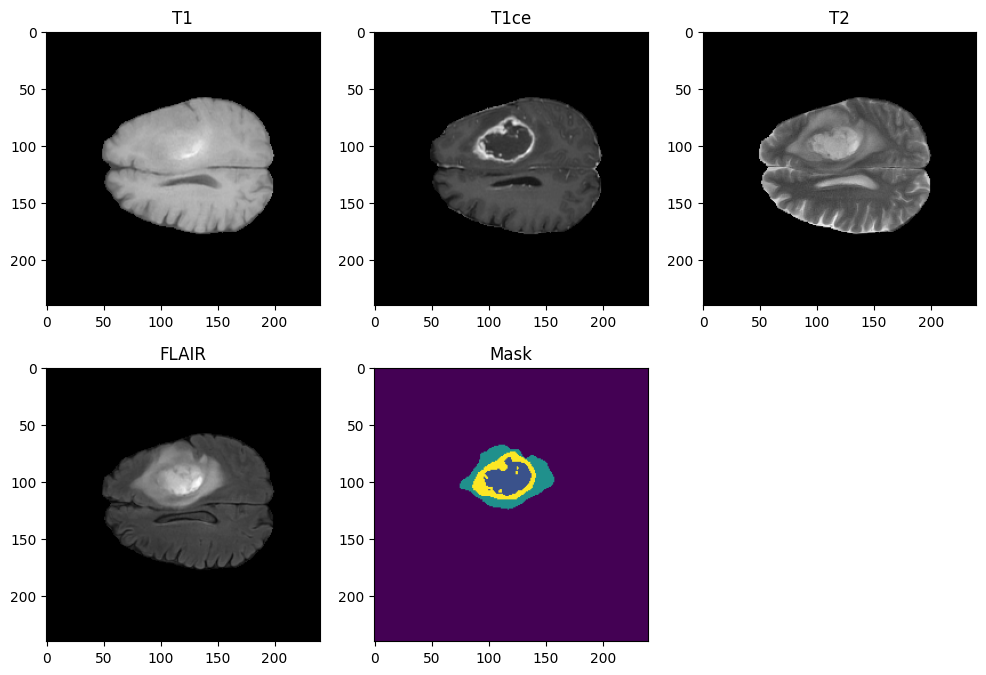

In [16]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

The four imaging modalities provide distinct perspectives on the same brain image, each highlighting different features.

**Detailed Description of Each Modality:**

1. **Native (T1):** This modality reveals the structure and composition of various tissue types in the brain. It's instrumental in identifying tumors, cysts, and other abnormalities.
2. **Post-contrast T1-weighted (T1ce, also known as T1Gd):** Similar to T1 images, but enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
3. **T2-weighted (T2):** This modality highlights the fluid content within brain tissues.
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** This technique suppresses the fluid signals, making it easier to identify lesions that may not be visible on T1 or T2 images. It is particularly useful for detecting lesions in the brain's white matter, which are challenging to spot with other scans.

For medical experts, these four modalities collectively provide a comprehensive view, aiding in precise tumor analysis and confirmation. However, in our artificial intelligence approach, we aim to streamline the process by reducing computational and memory demands. Utilizing only two modalities can achieve this, making the segmentation task faster and more efficient.

To optimize our model, we will exclude the T1 modality since its enhanced counterpart, **T1ce**, provides better clarity. Similarly, we will omit the T2 modality because the fluids it highlights could negatively impact our predictions. Instead, the **T2-FLAIR** modality, which effectively highlights affected regions by suppressing fluid signals, will be more beneficial for our training.

### Images Format

You may have noticed that these images are in the .nii format. These scans are NIfTI files (Neuroimaging Informatics Technology Initiative). A NIfTI image provides a digital representation of a 3D object, such as a brain in our case. The NIfTI format is widely used in neuroimaging because it efficiently handles complex, multi-dimensional data and includes metadata for spatial orientation and scaling.

To gain a better understanding of the data structure, let's examine the shape of a modality scan and a segmentation mask. Note that in this dataset, all modalities and their corresponding segmentation masks share the same dimensions:

In [17]:
print("Modality: ", test_image_t1.shape)
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, the modalities and segmentations have 3 dimensions. Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation. For instance, in our previous example, we displayed the 95th slice of a certain dimension.

These 3 dimensions correspond to the three spatial dimensions of the image: width, height, and depth. In medical imaging, these dimensions are referred to as the axial (transverse), coronal, and sagittal planes, corresponding to the three main orientations of the human body and, therefore, the human brain.

Here is a quick presentation of these 3 planes:

1. **Axial (Transverse) Plane:** This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
2. **Coronal (Frontal) Plane:** This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
3. **Sagittal (Lateral) Plane:** This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Understanding these planes is crucial for accurately interpreting medical images and effectively utilizing them in segmentation tasks. Each plane provides a different perspective, helping to localize and identify anatomical structures and abnormalities.

Slice number: 95


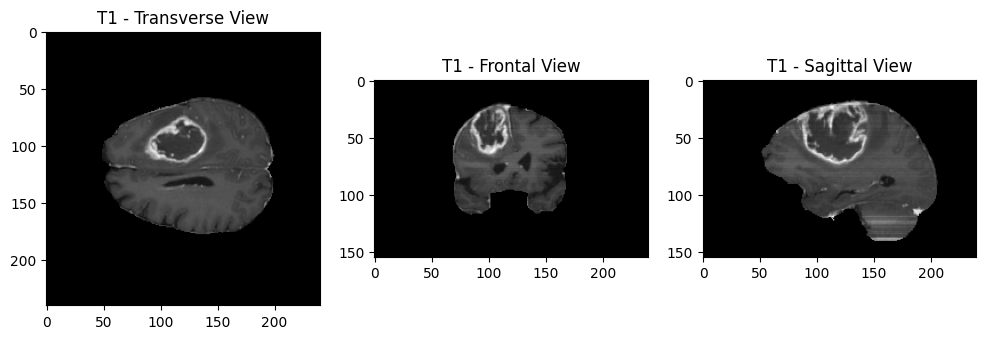

In [18]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90deg rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View

plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

This visualization helps illustrate how each plane cuts through the brain and highlights different anatomical features, aiding in comprehensive analysis and segmentation.

---
Now that we understand the three dimensions, let's explore why we chose to display a specific slice, setting the slice number to 95. By examining all the slices, we can identify the slice that best represents the region of interest, such as the area where a tumor is located.

To visualize this, we will display all the slices along one dimension:

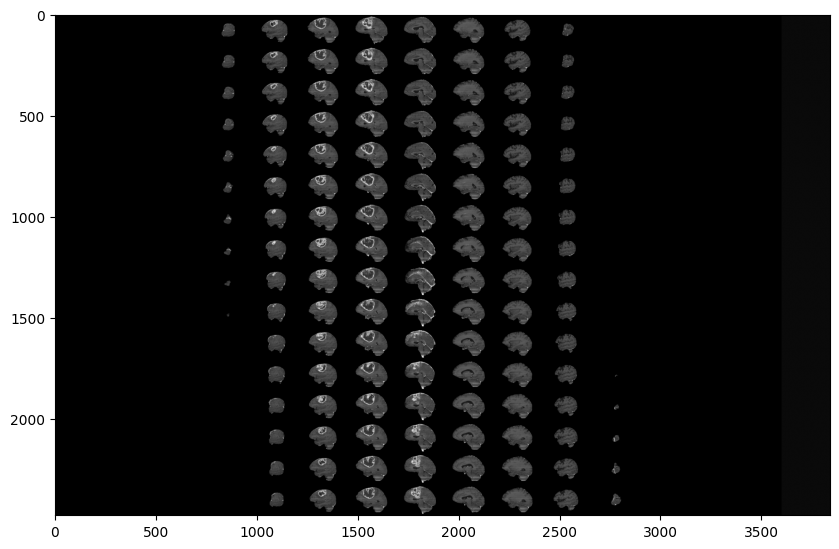

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

As you can see, two black parts are present on each side of our montage. These black parts correspond to the first and last slices of the plane. This indicates that a large portion of the slices does not contain much information, which is expected as the slices progressively represent the brain from one end to the other.

This observation is consistent across all modalities, planes, and even the expert-segmented images. The experts were unable to segment the slices that lack significant information, as these slices mostly capture areas outside the brain or the outermost regions that do not contain relevant anatomical details.

To further illustrate this, let's visualize a range of slices:

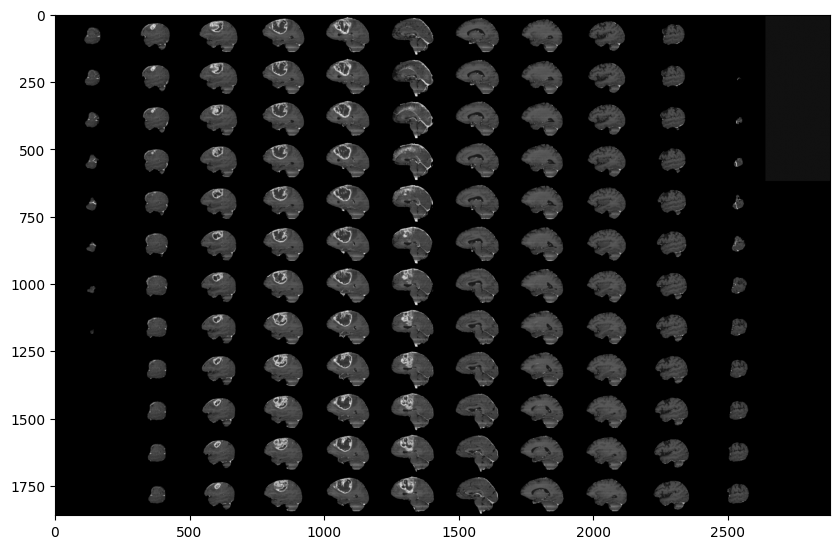

In [20]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

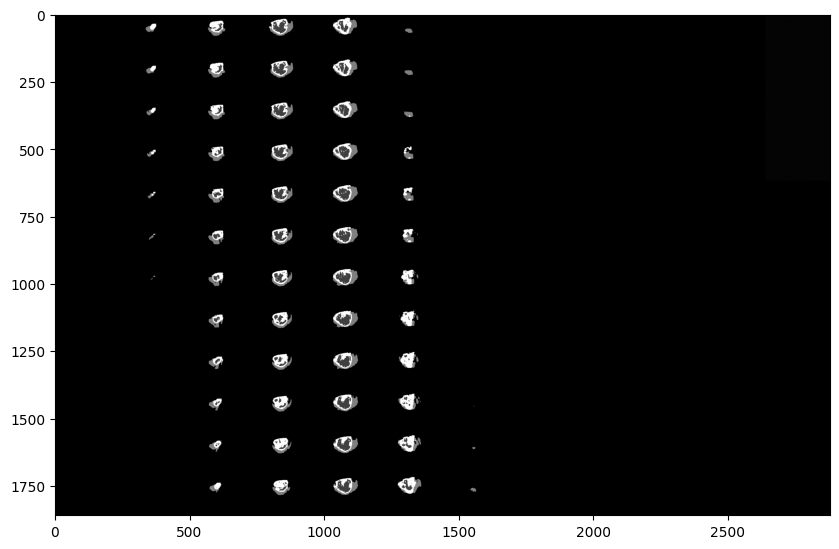

In [21]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

By focusing on a range of slices that contain meaningful content, we can better understand the anatomical structures and the regions where abnormalities, such as tumors, may be present. This approach helps in identifying the slices that are most relevant for analysis and segmentation.

This analysis applies to all other modalities and planes as well. The segmented images by experts also reflect this pattern, as they concentrate on the slices containing significant information. Slices that do not capture much of the brain's anatomy are often left unsegmented, as they provide little to no valuable data for diagnosis or analysis.

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:

1. **Location:** Identifies the exact location of the tumor in the brain.
2. **Size and Shape:** Measures the tumor's dimensions and form.
3. **Type:** Helps differentiate between various tumor types.
4. **Heterogeneity:** Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. **Surrounding Tissue Involvement:** Shows how the tumor interacts with adjacent brain structures.
6. **Cross-Modality Comparison:** Provides a comprehensive view by comparing different imaging modalities.

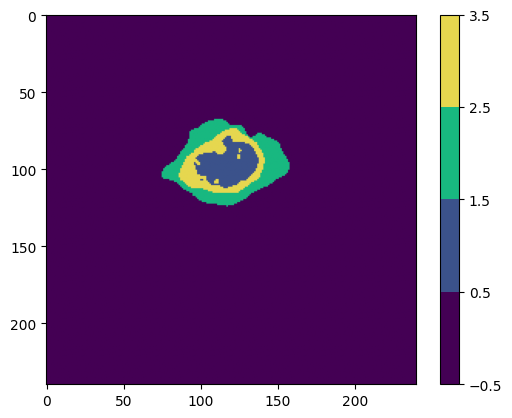

In [22]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

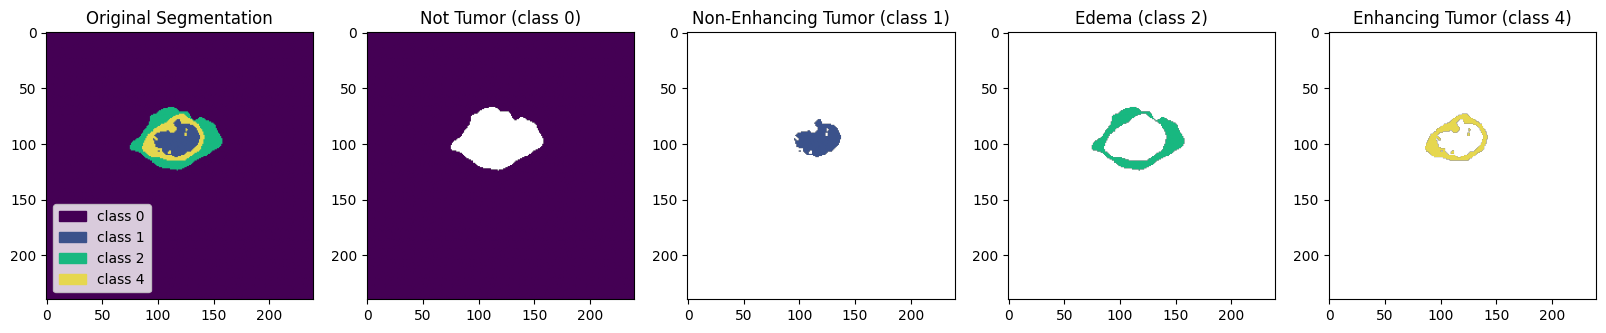

In [23]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

These insights are essential for accurate diagnosis, treatment planning, and monitoring. The segmentations help visualize the tumor clearly, making it easier to understand its characteristics and interactions with surrounding tissues.

---

To summarize our data exploration:

- **Modalities:** Each sample/patient has 4 different modalities (T1, T1CE, T2, and FLAIR), accompanied by a segmentation indicating tumor areas.
- **Selected Modalities:** We will focus on T1CE and FLAIR as they provide complementary information about the brain's anatomy and tissue contrast.
- **3D Images:** Each image is 3D and can be analyzed through 3 different planes composed of 2D slices.
- **Informative Slices:** Many slices contain little or no information. We will use slices in the (50:-50) interval. You can customize this range, but note that changing it may affect training time.
- **Segmentation Classes:** Segmentation images contain 1 to 4 classes. Class 4 will be reassigned to 3 since class 3 is missing.
- **Background Class:** Class 0 (background) is over-represented. Cropping might remove important information, so we will keep the images as they are.

Now that we understand our data better, it's time to prepare for model training.

# Split the Dataset

To train and evaluate our model effectively, we need to split our dataset into three parts: the training set (70-80%) for training the model, the validation set (10-15%) for tuning hyperparameters and preventing overfitting, and the test set (10-15%) for evaluating the final model's performance. We can use random splitting to divide the data or stratified splitting to maintain the same class distribution across sets, which is particularly useful for imbalanced datasets. Properly splitting the dataset ensures that our model is robust and performs well on unseen data.

In [24]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [25]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


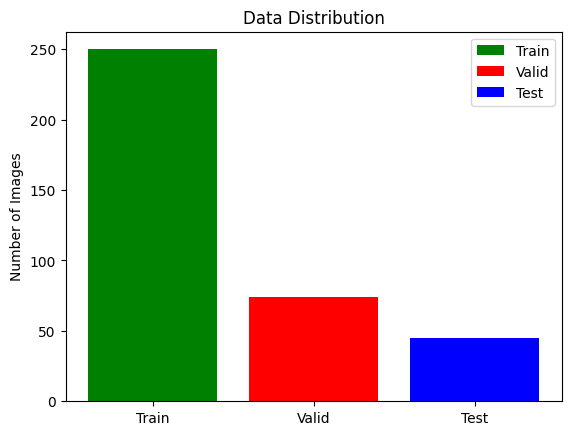

In [26]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

# Image DataGenerator - Pipelinning


To train a neural network for image segmentation, we need both raw image data (X) and ground truth segmentations (y). This allows the network to learn tumor patterns and make accurate predictions from patient scans. However, directly loading all 3D images can overload system memory and cause shape mismatch errors. Therefore, we use a Data Generator for image preprocessing, which includes several steps:

1. **Retrieve paths:** Obtain the paths for the T1CE and FLAIR modalities (for complementary anatomical and tissue contrast information) and the ground truth segmentation.
2. **Load data:** Load the selected slices (60-135) from these modalities and the corresponding segmentation.
3. **Create arrays:** Form X arrays with the slices from T1CE and FLAIR, and y arrays with the segmentation slices.
4. **Class reassignment:** Assign a value of 3 to all instances of 4 in the mask array to correct the missing class issue.

Additional preprocessing steps include:

- **Axial plane:** Use the axial plane for its square shape (240x240). This enables visualizing predictions across all planes without impact.
- **One-Hot Encoding:** Apply One-Hot Encoding to the y array to convert classes (0 to 3) into a numerical format suitable for neural networks, avoiding any implied hierarchy between classes. Here is what it consists of, for one slice:
   ![one_hot_encoding.png](attachment:one_hot_encoding.png)
<br>
- **Resize images:** Resize each slice from (240x240) to (128x128). This shape is chosen because it is a power of two, fitting well with pooling layers (MaxPooling2D) in CNNs, and balances computational efficiency and information preservation.

While resizing to (256x256) could retain more detail, it significantly increases training time and memory usage. We can choose to train with (256x256) images, but we’ll need to adjust your U-Net architecture accordingly.

Now that we have a clear understanding of our data and preprocessing steps, we can proceed to prepare our model for training.

In [27]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [28]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

### Preprocessing Steps Summary

- **Data Generator:** Utilized to process and send data to the neural network without overloading memory.
- **Epoch Handling:** For each epoch, the model processes 250 samples from the training dataset.
- **Sample Analysis:** Each sample consists of 150 slices (100 slices each from two modalities) resized to (128, 128).
- **Data Shapes:**
  - **X Array:** Shape (128, 128, 100, 2) for input images.
  - **Ground Truth (y):** One-Hot encoded segmentation with shape (100, 128, 128, 4).

This preprocessing setup ensures efficient data handling and preparation for training the neural network.

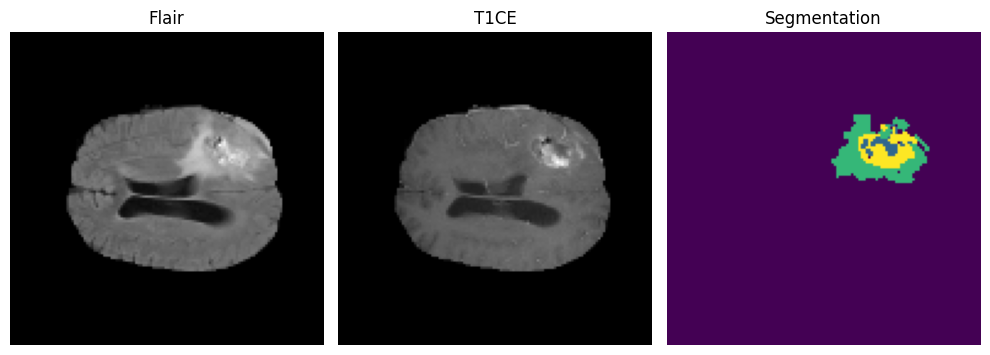

In [29]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)


# Building the U-Net Model



### U-Net

We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation. U-Net is particularly effective for segmenting regions of interest that are small and have complex shapes, such as tumors in MRI scans. This architecture was introduced in 2015 by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

Since the BraTS2020 dataset consists of 3D images, with each image comprising multiple 2D slices in three orthogonal planes, we have two options: using a 2D U-Net or a 3D U-Net.

- **3D U-Net:** More suitable for leveraging the 3D spatial context of the images, reducing the risk of false positives and false negatives from partial information in individual slices. However, it requires more computational resources and memory.
- **2D U-Net:** Faster and requires less memory, advantageous when working with large datasets or limited computational resources.

In practice, it’s useful to try both architectures and compare their performance. We will opt for a 2D U-Net implementation due to its efficiency and lower resource requirements.

In [33]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

Here is the visual representation of our model:

![U-Net%20%281%29.png](attachment:U-Net%20%281%29.png)

## Build and Plot the Model

In [44]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

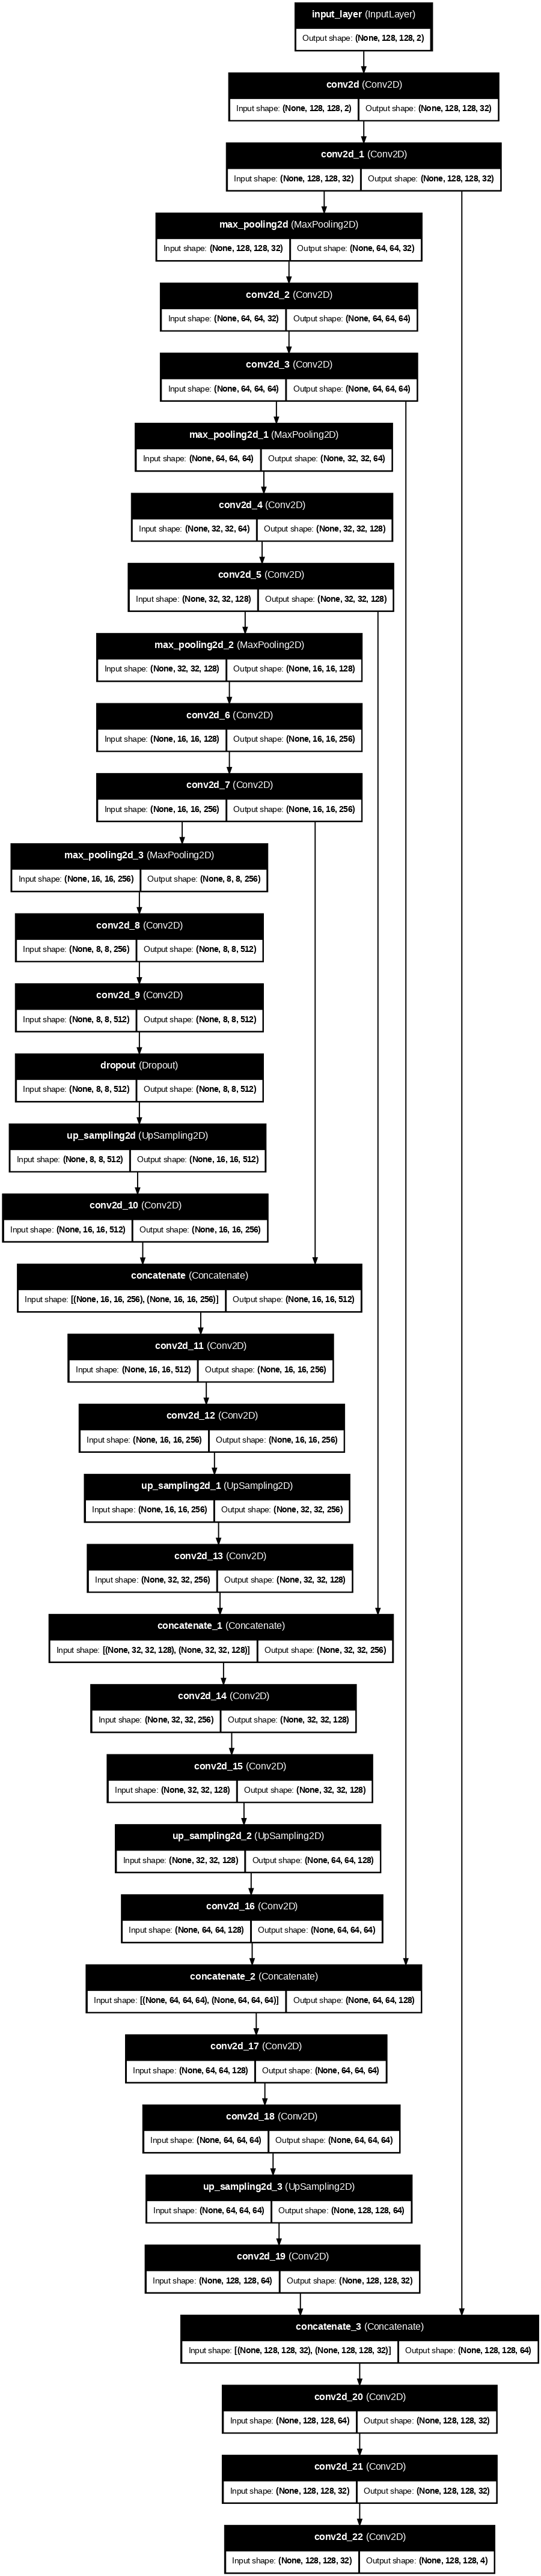

In [39]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

## Set up callbacks

In [40]:
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                          verbose=1, save_best_only=True, save_weights_only = True),
      CSVLogger('training.log', separator=',', append=False),
      keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
    ]

# Model Training

We are now ready to train our deep neural network using the `.fit()` method in Keras. We will pass our three callbacks to this method to be executed during the training process, which will last for 35 epochs.

In [45]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator)

Epoch 1/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9624 - loss: 0.2620
Epoch 1: val_loss improved from inf to 0.10109, saving model to model_.01-0.101090.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 195s 720ms/step - accuracy: 0.9625 - loss: 0.2614 - val_accuracy: 0.9827 - val_loss: 0.1011 - learning_rate: 0.0010
Epoch 2/35


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.10109
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9827 - val_loss: 0.1011 - learning_rate: 0.0010
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9819 - loss: 0.0879
Epoch 3: val_loss improved from 0.10109 to 0.07317, saving model to model_.03-0.073170.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 171s 673ms/step - accuracy: 0.9820 - loss: 0.0879 - val_accuracy: 0.9827 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 4/35

Epoch 4: val_loss improved from 0.07317 to 0.07317, saving model to model_.04-0.073170.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9827 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 5/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9834 - loss: 0.0726
Epoch 5: val_loss improved from 0.07317 to 0.06633, saving model to model_.05-0.066325.weights.h5
250/250 ━━━━━━━━━━━━━━

## Saving Model

In [46]:
model.save("model.keras")
model.save("model.h5")

# Model Metrics Visualization
Now that the training is complete, we can examine the CSVLogger callback to gain insights into the training process and our model's performance. The CSVLogger records metrics such as accuracy, loss, Dice coefficient, and Mean IoU for each epoch, allowing us to track the model’s progress over time. By analyzing this log, we can identify trends, assess the effectiveness of our training strategy, and make informed decisions for future improvements. This thorough review ensures our model is performing optimally and ready for deployment.

In [ ]:
hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

plt.show()

The accuracy graph shows that both training and validation accuracy increase over the epochs and reach a plateau, indicating that the model is learning from the data and generalizing well without overfitting.

The loss graph demonstrates that both training and validation losses decrease over time, further confirming that the model is effectively learning from the data. Notably, the best model performance is achieved around epoch 19, as indicated in the training logs.

Finally, the Dice coefficient graph shows a steady increase in both training and validation Dice coefficients, reinforcing that the model's segmentation capabilities are improving consistently.

# Model Predictions

Now that our model is trained, we can use it to predict segmentations on our test dataset. There are two main options:

1. **Best Model's Weights (from epoch 19):** Using the weights from the epoch where the model performed best.
2. **Final Model's Weights:** Using the weights from the final epoch of training.

Using the final model's weights may not always yield the best performance on new, unseen data. In our case, there is no significant difference between the two options, so either can be used. However, for other cases, you might prefer a specific version of your model. You can load it with the following code:

In [47]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])

best_saved_model.load_weights('model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


This allows you to select and use the optimal model version for your specific needs.

---

Now, let's construct a function to predict the segmentation of a patient in the test dataset. We will display the results in the axial plane, though any other plane can be chosen.

In [48]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [49]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [50]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [51]:
def showPredictsById(case, start_slice = 60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


<Figure size 1800x5000 with 0 Axes>

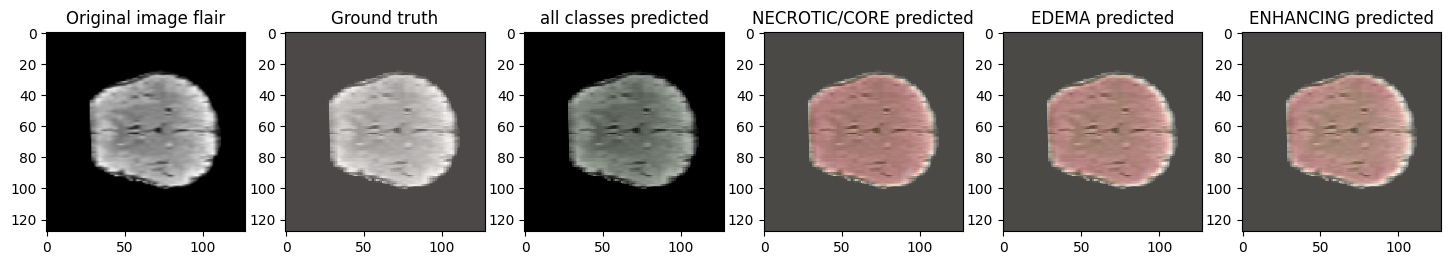

In [52]:
showPredictsById(case=test_ids[0][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


<Figure size 1800x5000 with 0 Axes>

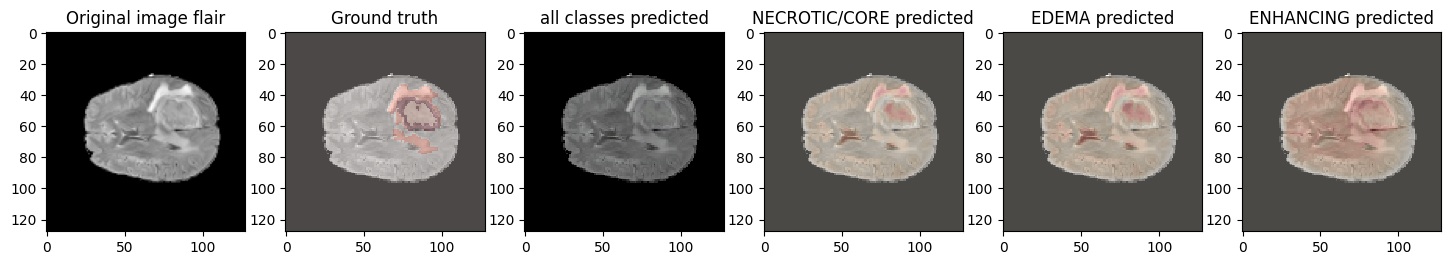

In [53]:
showPredictsById(case=test_ids[1][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


<Figure size 1800x5000 with 0 Axes>

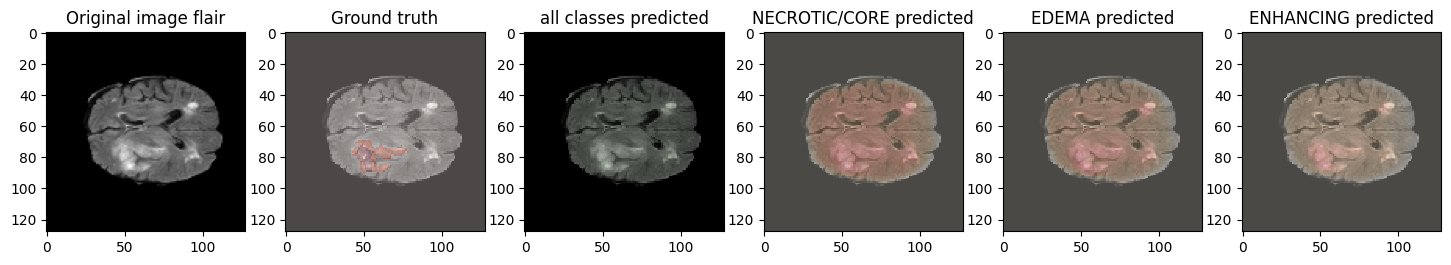

In [54]:
showPredictsById(case=test_ids[2][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


<Figure size 1800x5000 with 0 Axes>

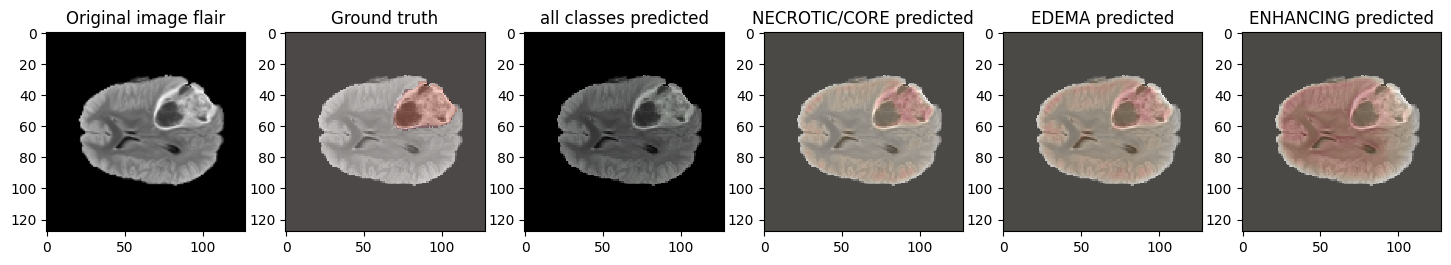

In [55]:
showPredictsById(case=test_ids[3][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 1800x5000 with 0 Axes>

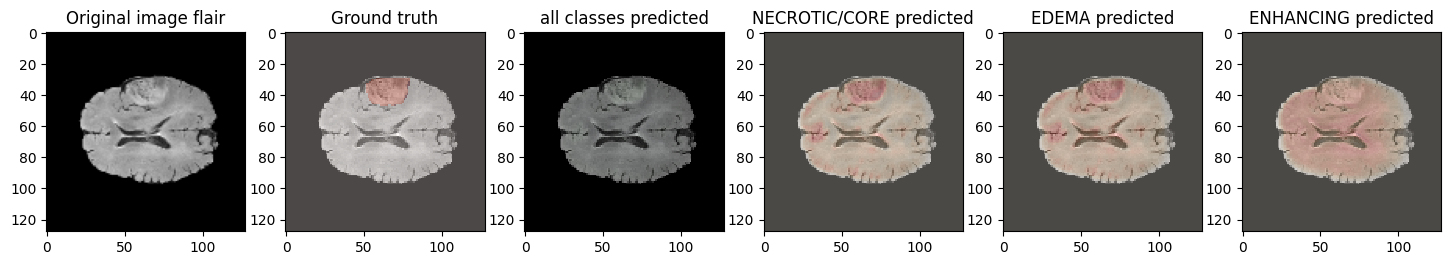

In [56]:
showPredictsById(case=test_ids[4][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 1800x5000 with 0 Axes>

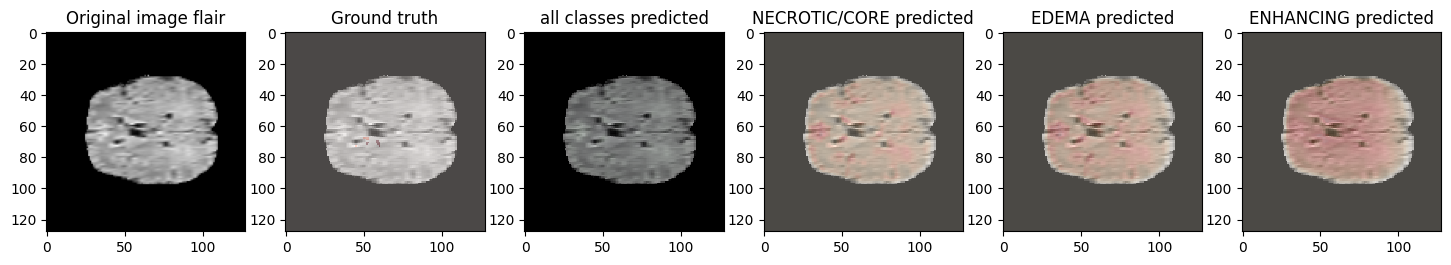

In [57]:
showPredictsById(case=test_ids[5][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 1800x5000 with 0 Axes>

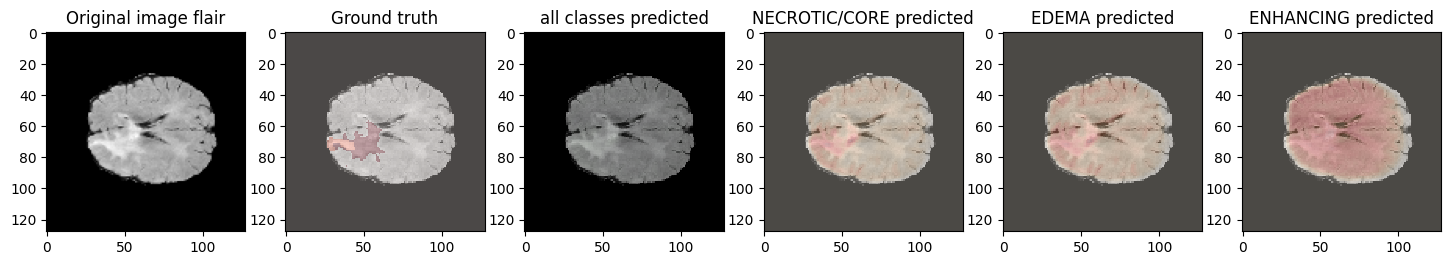

In [58]:
showPredictsById(case=test_ids[6][-3:])

### Outline:
- Load `NIfTI (.nii)` files of the sample (patient)
- Extract the data from these paths
- Create an empty array
- Perform the same operations as our DataGenerator, to keep the same input shape
- Send our images to the CNN model and return predicted segmentation

In [59]:
def predict_segmentation(sample_path):

    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

### Outline:
- Choose a random patient
- Get path of this patient
- Predict patient's segmentation
- Load patient's original segmentation (Ground truth)
- Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
- Differentiate segmentations by their labels
- Plot Original segmentation & predicted segmentation
- Original segmentation

In [60]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):

    random_sample = random.choice(samples_list)

    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    predicted_seg = predict_segmentation(random_sample_path)

    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    all = predicted_seg[slice_to_plot,:,:,1:4]
    zero = predicted_seg[slice_to_plot,:,:,0]
    first = predicted_seg[slice_to_plot,:,:,1]
    second = predicted_seg[slice_to_plot,:,:,2]
    third = predicted_seg[slice_to_plot,:,:,3]

    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    plt.subplots_adjust(wspace=0.8)

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Patient number:  BraTS20_Training_107


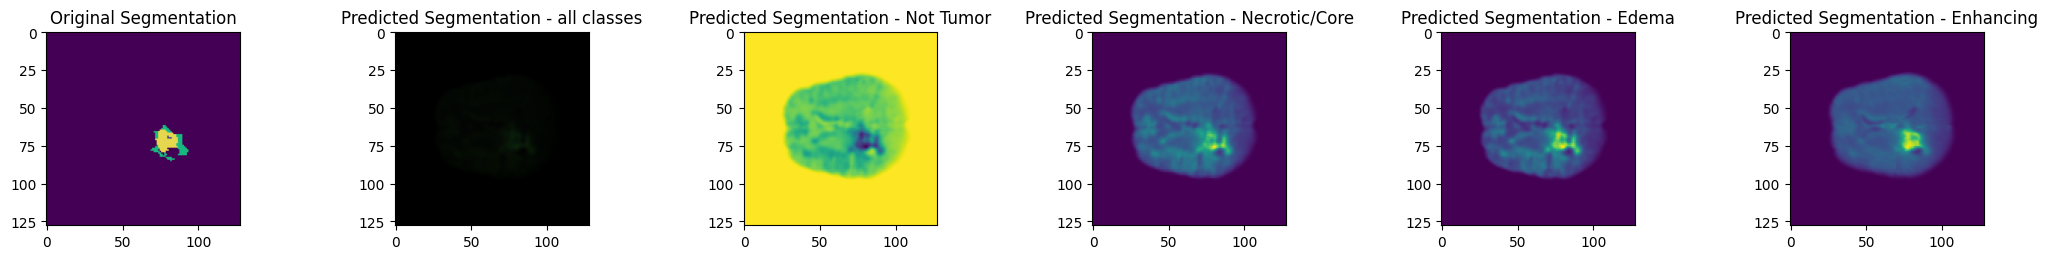

In [61]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Patient number:  BraTS20_Training_107


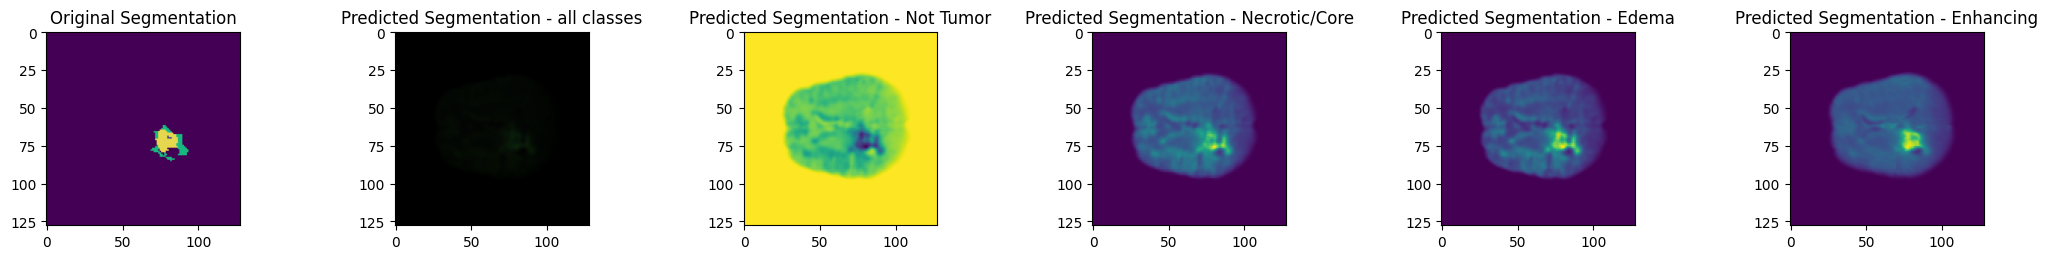

In [62]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Patient number:  BraTS20_Training_339


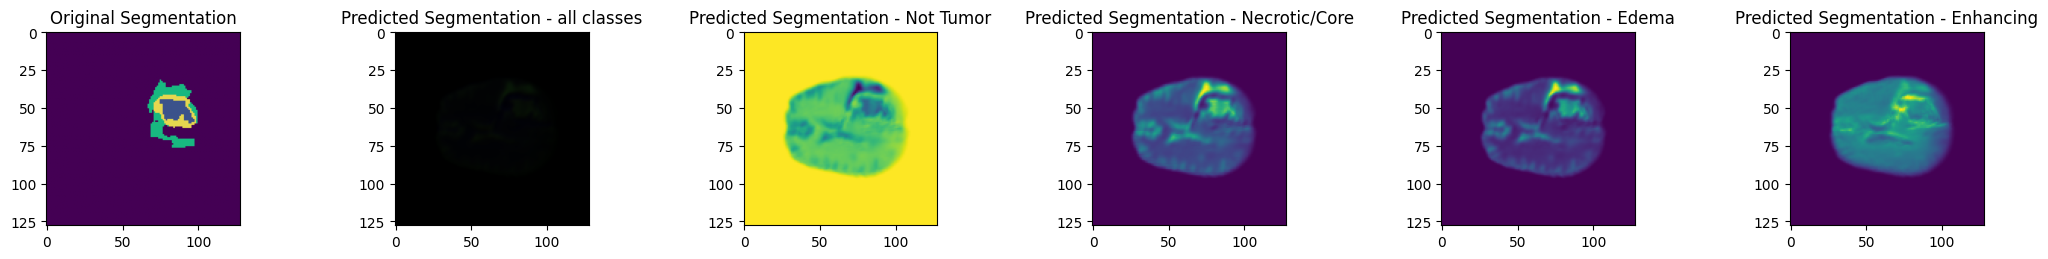

In [63]:
show_predicted_segmentations(test_ids, 65, cmap, norm)

### Outline
     0 : 'NOT tumor',  
     1 : 'ENHANCING',    
     2 : 'CORE',    
     3 : 'WHOLE'

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<Figure size 640x480 with 0 Axes>

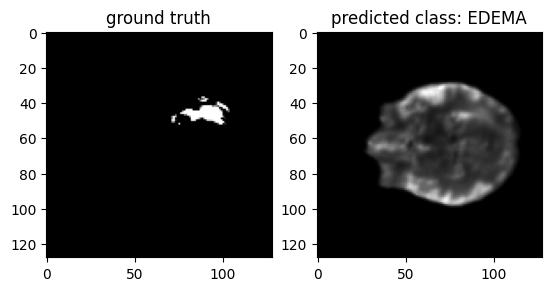

In [64]:
case = test_ids[3][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40
eval_class = 2

gt[gt != eval_class] = 1

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

# 12. Evaluation

Let's call the `evaluate()` function to evaluate the performance of our model on our test dataset:

In [65]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

results = model.evaluate(test_generator, batch_size=128, callbacks= callbacks)

descriptions = ["Loss", "Accuracy"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - accuracy: 0.9817 - loss: 0.0686

Model evaluation on the test set:
Loss : 0.0703
Accuracy : 0.9827
